In [1]:
import keras
keras.__version__

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.2.0'

In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '../datasets/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20


def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size:(i + 1) * batch_size] = features_batch
        labels[i * batch_size:(i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels


train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [6]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 516us/step - loss: 0.6186 - acc: 0.6485 - val_loss: 0.4524 - val_acc: 0.8200
Epoch 2/30
2000/2000 [==============================] - 1s 293us/step - loss: 0.4399 - acc: 0.8050 - val_loss: 0.3695 - val_acc: 0.8620
Epoch 3/30
2000/2000 [==============================] - 1s 289us/step - loss: 0.3571 - acc: 0.8465 - val_loss: 0.3271 - val_acc: 0.8810
Epoch 4/30
2000/2000 [==============================] - 1s 287us/step - loss: 0.3168 - acc: 0.8660 - val_loss: 0.3035 - val_acc: 0.8860
Epoch 5/30
2000/2000 [==============================] - 1s 285us/step - loss: 0.2922 - acc: 0.8890 - val_loss: 0.2877 - val_acc: 0.8940
Epoch 6/30
2000/2000 [==============================] - 1s 284us/step - loss: 0.2685 - acc: 0.8985 - val_loss: 0.2761 - val_acc: 0.8980
Epoch 7/30
2000/2000 [==============================] - 1s 283us/step - loss: 0.2470 - acc: 0.9030 - val_loss: 0.2986 - val_acc: 0.8660


In [7]:
import matplotlib.pyplot as plt

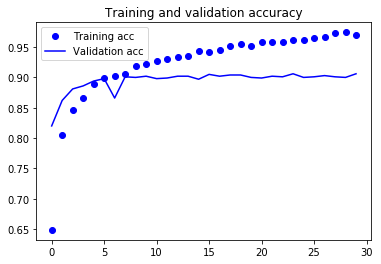

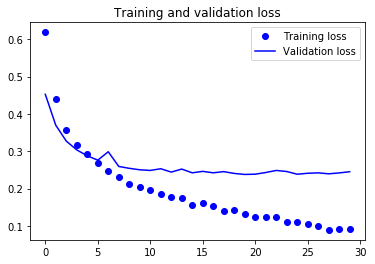

In [8]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [9]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [12]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [13]:
conv_base.trainable = False

In [15]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [16]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 27s - loss: 0.5800 - acc: 0.6995 - val_loss: 0.4415 - val_acc: 0.8180
Epoch 2/30
 - 25s - loss: 0.4866 - acc: 0.7705 - val_loss: 0.3611 - val_acc: 0.8640
Epoch 3/30
 - 25s - loss: 0.4358 - acc: 0.8105 - val_loss: 0.3376 - val_acc: 0.8570
Epoch 4/30
 - 26s - loss: 0.3966 - acc: 0.8195 - val_loss: 0.3027 - val_acc: 0.8850
Epoch 5/30
 - 25s - loss: 0.3940 - acc: 0.8280 - val_loss: 0.2999 - val_acc: 0.8710
Epoch 6/30
 - 25s - loss: 0.3679 - acc: 0.8345 - val_loss: 0.2843 - val_acc: 0.8850
Epoch 7/30
 - 25s - loss: 0.3655 - acc: 0.8340 - val_loss: 0.2701 - val_acc: 0.8870
Epoch 8/30
 - 25s - loss: 0.3472 - acc: 0.8555 - val_loss: 0.2657 - val_acc: 0.8910
Epoch 9/30
 - 25s - loss: 0.3526 - acc: 0.8480 - val_loss: 0.2646 - val_acc: 0.8920
Epoch 10/30
 - 26s - loss: 0.3334 - acc: 0.8655 - val_loss: 0.2582 - val_acc: 0.8930
Epoch 11/30
 - 25s - loss: 0.3339 - acc: 0.8620 - val_loss: 0.2700 - val_ac

In [18]:
model.save('cats_and_dogs_small_3.h5')

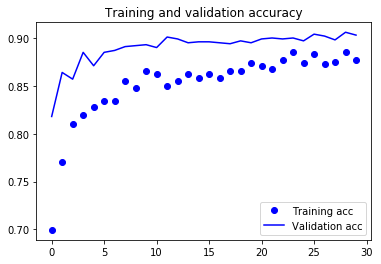

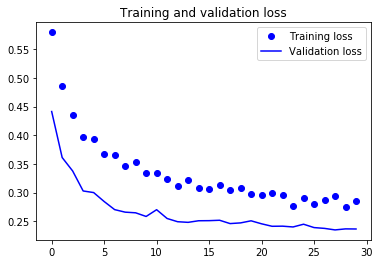

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [21]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [22]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 28s 277ms/step - loss: 0.2777 - acc: 0.8725 - val_loss: 0.2200 - val_acc: 0.9160
Epoch 2/100
100/100 [==============================] - 26s 258ms/step - loss: 0.2632 - acc: 0.8890 - val_loss: 0.2294 - val_acc: 0.9020
Epoch 3/100
100/100 [==============================] - 26s 258ms/step - loss: 0.2261 - acc: 0.9010 - val_loss: 0.2025 - val_acc: 0.9250
Epoch 4/100
100/100 [==============================] - 25s 254ms/step - loss: 0.2240 - acc: 0.9015 - val_loss: 0.2151 - val_acc: 0.9170
Epoch 5/100
100/100 [==============================] - 26s 256ms/step - loss: 0.2149 - acc: 0.9115 - val_loss: 0.1848 - val_acc: 0.9270
Epoch 6/100
100/100 [==============================] - 25s 254ms/step - loss: 0.1883 - acc: 0.9250 - val_loss: 0.1971 - val_acc: 0.9270
Epoch 7/100
100/100 [==============================] - 25s 255ms/step - loss: 0.1763 - acc: 0.9280 - val_loss: 0.1887 - val_acc: 0.9290
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 25s 254ms/step - loss: 0.0381 - acc: 0.9875 - val_loss: 0.2516 - val_acc: 0.9380
Epoch 62/100
100/100 [==============================] - 26s 261ms/step - loss: 0.0344 - acc: 0.9855 - val_loss: 0.2141 - val_acc: 0.9430
Epoch 63/100
100/100 [==============================] - 25s 254ms/step - loss: 0.0352 - acc: 0.9865 - val_loss: 0.2748 - val_acc: 0.9320
Epoch 64/100
100/100 [==============================] - 25s 254ms/step - loss: 0.0277 - acc: 0.9915 - val_loss: 0.2533 - val_acc: 0.9380
Epoch 65/100
100/100 [==============================] - 26s 256ms/step - loss: 0.0315 - acc: 0.9910 - val_loss: 0.2616 - val_acc: 0.9380
Epoch 66/100
100/100 [==============================] - 26s 257ms/step - loss: 0.0274 - acc: 0.9920 - val_loss: 0.2997 - val_acc: 0.9310
Epoch 67/100
100/100 [==============================] - 25s 255ms/step - loss: 0.0239 - acc: 0.9925 - val_loss: 0.2873 - val_acc: 0.9370
Epoch 68/100
100/100 [===================

In [23]:
model.save('cats_and_dogs_small_4.h5')

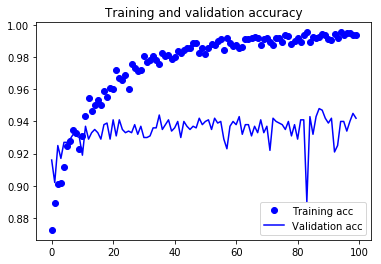

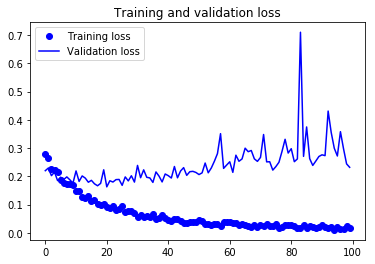

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

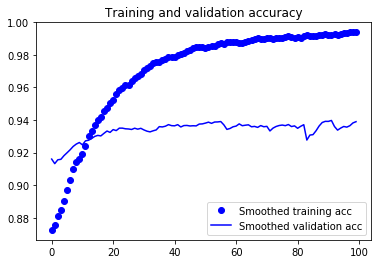

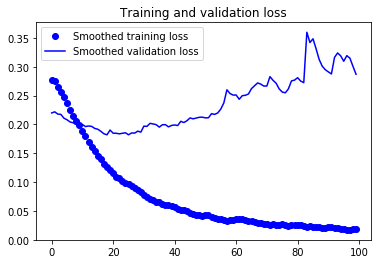

In [25]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [26]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9389999902248383
